In [ ]:
pip install split-folders

In [ ]:
!gdown --id '1KZ9CsoOL3uv_EPrrqXC8dPsg_HsRq1QO'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KZ9CsoOL3uv_EPrrqXC8dPsg_HsRq1QO
To: /content/Train.zip
100% 949M/949M [00:14<00:00, 65.1MB/s]


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
!nvidia-smi

Sun May 15 08:21:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip -qq '/content/Train.zip'

In [ ]:
input_dir = os.path.join('/content/train')
output_dir = os.path.join('/content/trainable2')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.2, .8), group_prefix=None) 

Copying files: 22424 files [00:04, 5575.94 files/s]


In [ ]:
input_dir = os.path.join('/content/trainable2/train')
output_dir = os.path.join('/content/train_split2')

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.7, .3), group_prefix=None) 

Copying files: 4481 files [00:01, 4423.16 files/s]


In [ ]:
train_dir = os.path.join('/content/train_split2/train')
test_dir = os.path.join('/content/train_split2/val')

In [ ]:
def image_generator(train_parent_directory, test_parent_directory):
    
  train_datagen = ImageDataGenerator(rescale=1/255)
  test_datagen = ImageDataGenerator(rescale=1/255)

  train_generator = train_datagen.flow_from_directory(train_parent_directory, target_size = (64,64), class_mode = 'categorical', subset='training')


  test_generator = test_datagen.flow_from_directory(test_parent_directory, target_size=(64,64), class_mode = 'categorical')    

  return train_generator, test_generator

In [ ]:
train_generator, test_generator = image_generator(train_dir, test_dir)

Found 3133 images belonging to 10 classes.
Found 1348 images belonging to 10 classes.


In [ ]:
divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/3133

model = Sequential([
    tfpl.Convolution2DReparameterization(input_shape=(64,64,3), filters=32, kernel_size=2, activation='relu', kernel_prior_fn = tfpl.default_multivariate_normal_fn, kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(64, 2, activation='relu', kernel_initializer='glorot_normal'),
    MaxPooling2D(2,2),
    Conv2D(128, 2, activation='relu', kernel_initializer='glorot_normal'),
    MaxPooling2D(2,2),
    Conv2D(256, 2, activation='relu', kernel_initializer='glorot_normal'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(10), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn),
    tfpl.OneHotCategorical(10)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


 conv2d_reparameterization_2  (None, 63, 63, 32)       832       
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       32896     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
          

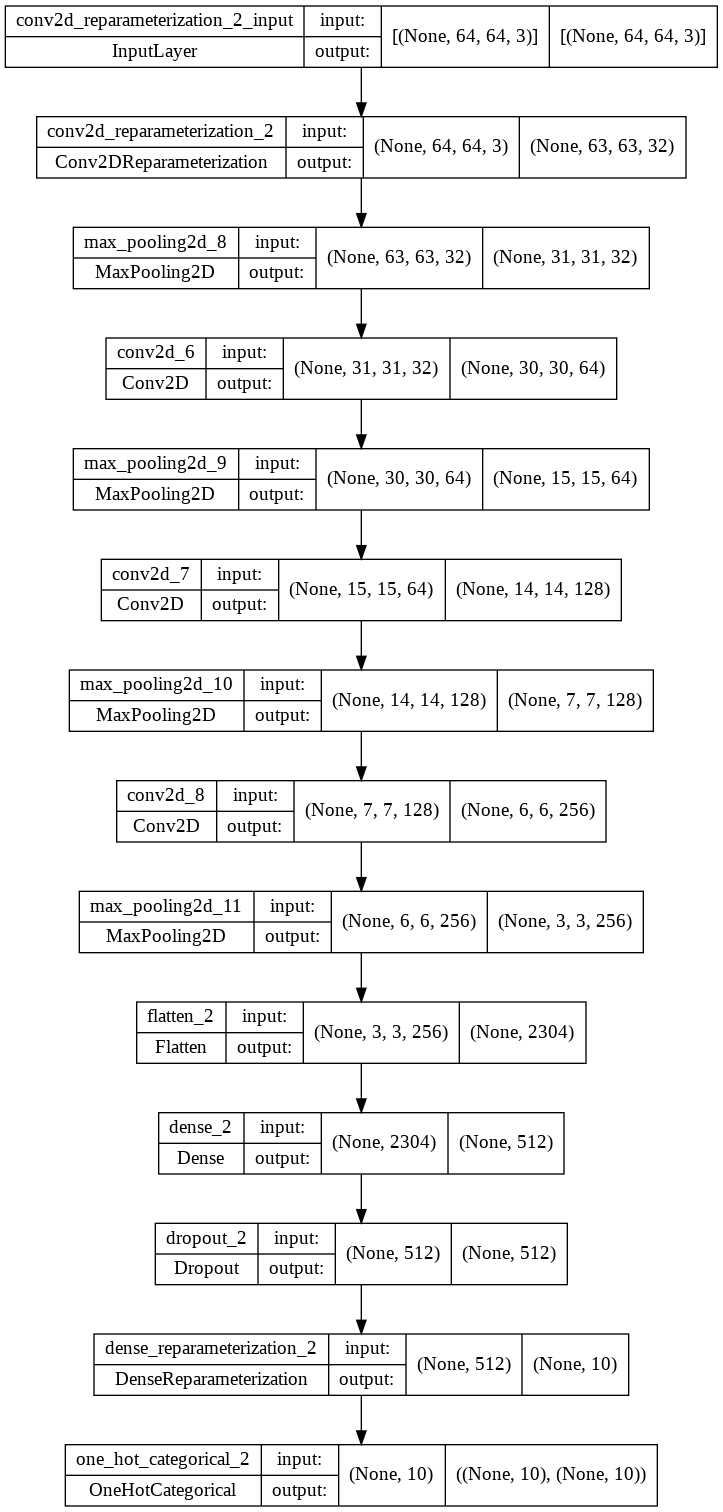

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

def negative_log_likelihood(y_true, y_pred):
  return -y_pred.log_prob(y_true)

model.compile(loss = negative_log_likelihood,
              optimizer = 'rmsprop',
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [ ]:
history = model.fit(train_generator, epochs=50)

Epoch 1/50
98/98 [==============================] - 15s 133ms/step - loss: 6.6610 - accuracy: 0.1104
Epoch 2/50
98/98 [==============================] - 13s 133ms/step - loss: 5.9724 - accuracy: 0.2477
Epoch 3/50
98/98 [==============================] - 13s 133ms/step - loss: 5.3555 - accuracy: 0.4363
Epoch 4/50
98/98 [==============================] - 13s 134ms/step - loss: 4.8585 - accuracy: 0.6064
Epoch 5/50
98/98 [==============================] - 13s 134ms/step - loss: 4.5252 - accuracy: 0.7143
Epoch 6/50
98/98 [==============================] - 13s 133ms/step - loss: 4.2688 - accuracy: 0.7852
Epoch 7/50
98/98 [==============================] - 13s 132ms/step - loss: 4.0580 - accuracy: 0.8446
Epoch 8/50
98/98 [==============================] - 13s 133ms/step - loss: 3.8902 - accuracy: 0.8781
Epoch 9/50
98/98 [==============================] - 13s 134ms/step - loss: 3.7332 - accuracy: 0.9042
Epoch 10/50
98/98 [==============================] - 13s 134ms/step - loss: 3.5840 - accura

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

label = os.listdir(test_dir)
label.sort()

def import_and_predict_bayes(image, true_label):

    #read image
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    
    #show the image
    plt.imshow(img)
    plt.axis('off')
    
    img_resize = (cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC))/255.
    
    predicted_probabilities = np.empty(shape=(300, 10))
    print(model(img_resize[np.newaxis,...]))
    
    for i in range(300):
        
        predicted_probabilities[i] = model(img_resize[np.newaxis,...]).mean().numpy()[0]
        
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])
    
    fig, ax = plt.subplots(figsize=(20, 6))
    bar = ax.bar(np.arange(10), pct_97p5, color='red')
    bar[true_label].set_color('green')
    bar = ax.bar(np.arange(10), pct_2p5-0.02, color='white')
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
    ax.set_xticklabels(['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

tfp.distributions._TensorCoercible("tensor_coercible", batch_shape=[1], event_shape=[10], dtype=float32)


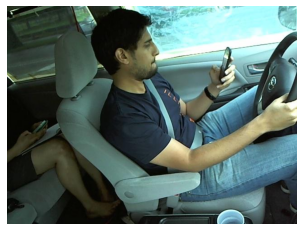

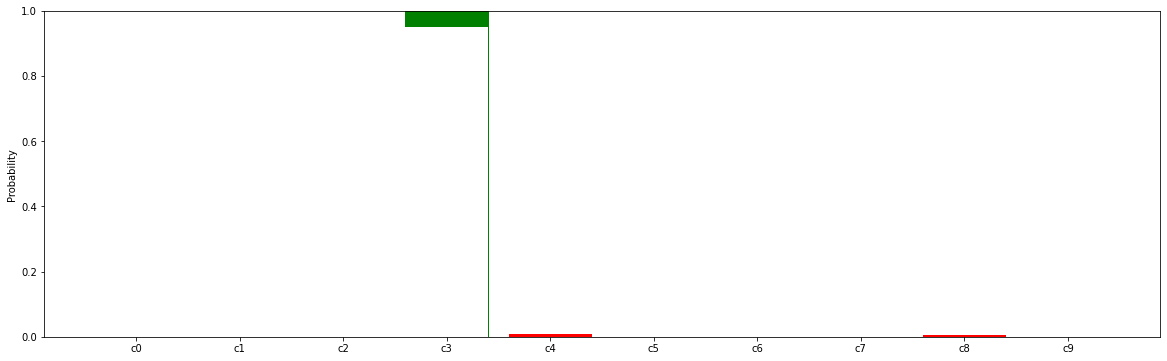

In [ ]:
img1_pth = '/content/train_split2/val/c3/img_66849.jpg'
import_and_predict_bayes(img1_pth, label.index('c3'))

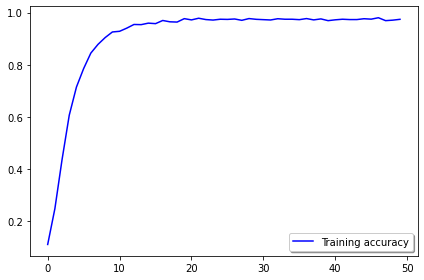

In [ ]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")

legend = plt.legend(loc='lower right', shadow=True)
plt.tight_layout()
plt.show()

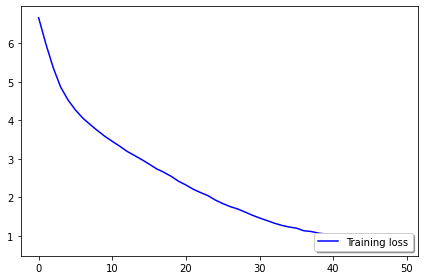

In [ ]:
plt.plot(history.history['loss'], color='b', label="Training loss")

legend = plt.legend(loc='lower right', shadow=True)
plt.tight_layout()
plt.show()